У цьому ДЗ ми попрактикуємось моделювати часові ряди на даних з [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview). Ми будемо працювати лише з тренувальними даними цього змагання і задача у нас буде дещо змінена. Фокус буде на пошуці найкращої моделі, експериментах і використанні функціоналу `darts`.

Якщо якісно попрацювати в цьому завданні - це буде чудовий приклад проєкту для вашого портфоліо: "спрогнозував(-ла) поденні продажі на 1 міс для 50 товарів в 10 магазинах" звучить вражаюче! Але ми в рамках ДЗ для оптимізації часу сконцентруємось на моделюванні продажів одного товару в одному магазині.

**Задача**

Вам надано дані про продажі товарів у магазинах за 5 років. Хочемо навчитись передачати продажі в наступному місяці поденно кожного з 50 товарів у кожному з 10 магазинів. Відповідно будемо проводити експерименти, аби знайти найкращу модель для цього.

На відміну від змагання, ми будемо використовувати метрику МАРЕ (Mean Absolute Percentage Error) замість SMAPE (Symmetric Mean Absolute Percentage Error). Проте, ви також можете розрахувати SMAPE і подати свої результати через late submission на Kaggle.

1. Завантажуємо дані в Pandas.

  1. Завантажте дані з файлу `train.csv.zip` за допомогою бібліотеки Pandas.
  2. Перетворіть колонку `date` на формат `datetime`.
  3. Встановіть колонку `date` як індекс для датафрейму.
  4. Виведіть перші 10 рядків отриманого датафрейму та інформацію про датафрейм.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.graphics.tsaplots import plot_pacf



In [2]:
df = pd.read_csv("train2_5.csv")

df["date"] = pd.to_datetime(df["date"])
df.set_index("date", inplace=True)

df.head(10), df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB


(            store  item  sales
 date                          
 2013-01-01      1     1     13
 2013-01-02      1     1     11
 2013-01-03      1     1     14
 2013-01-04      1     1     13
 2013-01-05      1     1     10
 2013-01-06      1     1     12
 2013-01-07      1     1     10
 2013-01-08      1     1      9
 2013-01-09      1     1     12
 2013-01-10      1     1      9,
 None)

  2. Давайте трошки зрозуміємо дані. У нас 10 магазинів і 50 айтемів в кожному. Хочемо зрозуміти, чи відрізняється динаміка по кожному айтему в магазинах. Як би ви це візуалізували? Побудуйте 3 графіка, які вам допоможуть. Можна використати будь-який інструмент: matplotlib, seaborn, plotly.

  Напишіть висновок з побудованих вами візуалізацій.
  
    **Підказка**: я б спробувала вивести середнє значення і довірчий інтервал (який включає весь діапазон значень з різних магазинів) для динаміки кожного айтема, або принаймні для декількох айтемів, аби зрозуміти тенденцію.



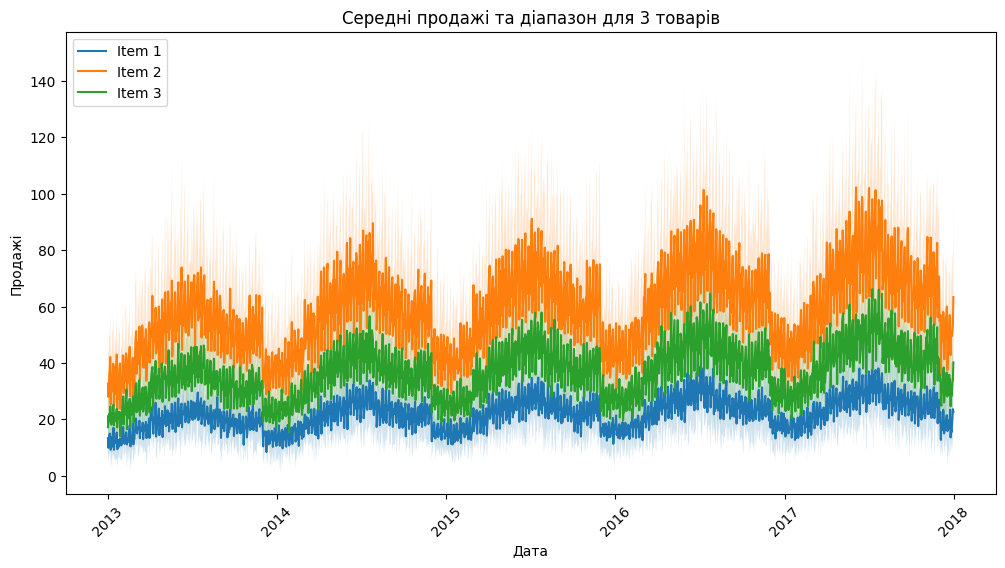

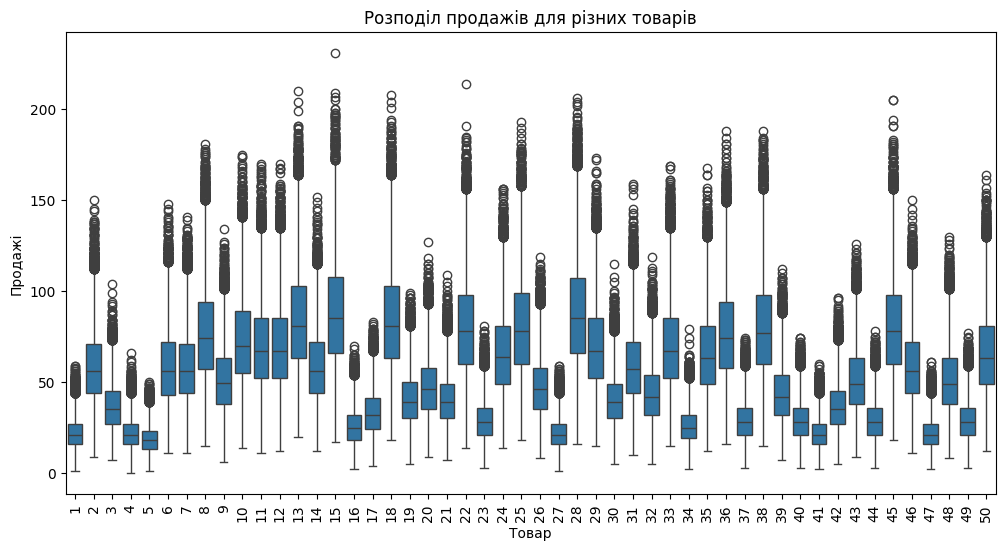

<ipython-input-3-173ff803659c>:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=df_sample, x="date", y="sales", hue="item", ci="sd")


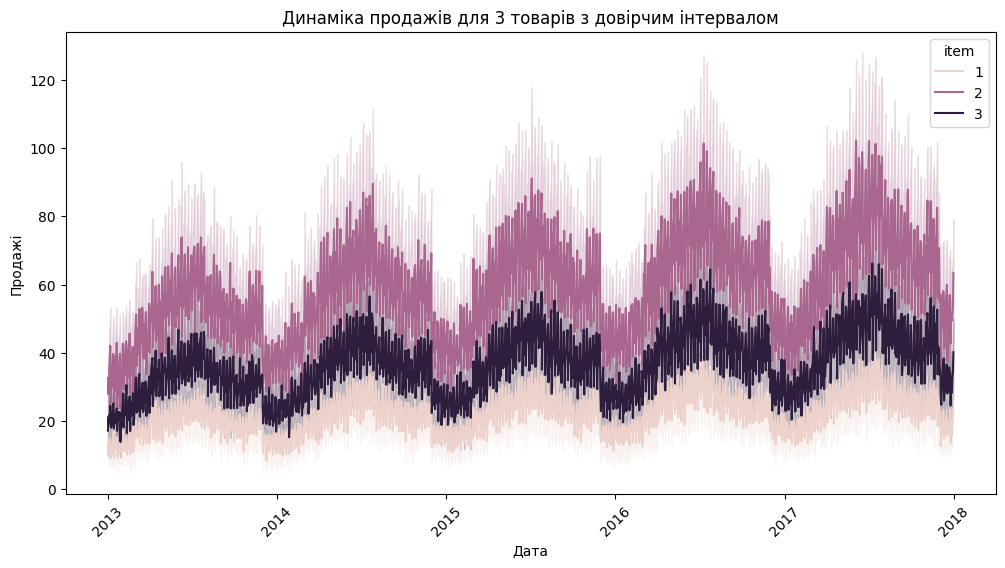

In [3]:
df_grouped = df.groupby(["date", "item"])["sales"].agg(["mean", "min", "max"]).reset_index()
df_grouped["date"] = pd.to_datetime(df_grouped["date"])

plt.figure(figsize=(12, 6))
for item_id in df_grouped["item"].unique()[:3]:
    item_data = df_grouped[df_grouped["item"] == item_id]
    plt.fill_between(item_data["date"].values, item_data["min"], item_data["max"], alpha=0.2)
    plt.plot(item_data["date"].values, item_data["mean"], label=f"Item {item_id}")
plt.xticks(rotation=45)
plt.legend()
plt.title("Середні продажі та діапазон для 3 товарів")
plt.xlabel("Дата")
plt.ylabel("Продажі")
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="item", y="sales")
plt.xticks(rotation=90)
plt.title("Розподіл продажів для різних товарів")
plt.xlabel("Товар")
plt.ylabel("Продажі")
plt.show()

df_sample = df[df["item"].isin(df["item"].unique()[:3])].reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_sample, x="date", y="sales", hue="item", ci="sd")
plt.xticks(rotation=45)
plt.title("Динаміка продажів для 3 товарів з довірчим інтервалом")
plt.xlabel("Дата")
plt.ylabel("Продажі")
plt.show()


3. **Для початку проаналізуємо лише один ряд, а далі зможемо зациклити тренування моделей.**
  
  Виберіть підмножину даних, що відповідає продажам товару з `item == 1` у магазині з `store == 1`.

  Зробіть декомпозицію цього рядку за адитивною моделлю на тренд, сезонність і залишки з бібліотекою `statsmodels`.

  Зробіть висновки з отриманих візуалізацій. Чи щось би могло вам допомогти ліпше зрозуміти ці візуалізації? (з точки зору обробки даних)

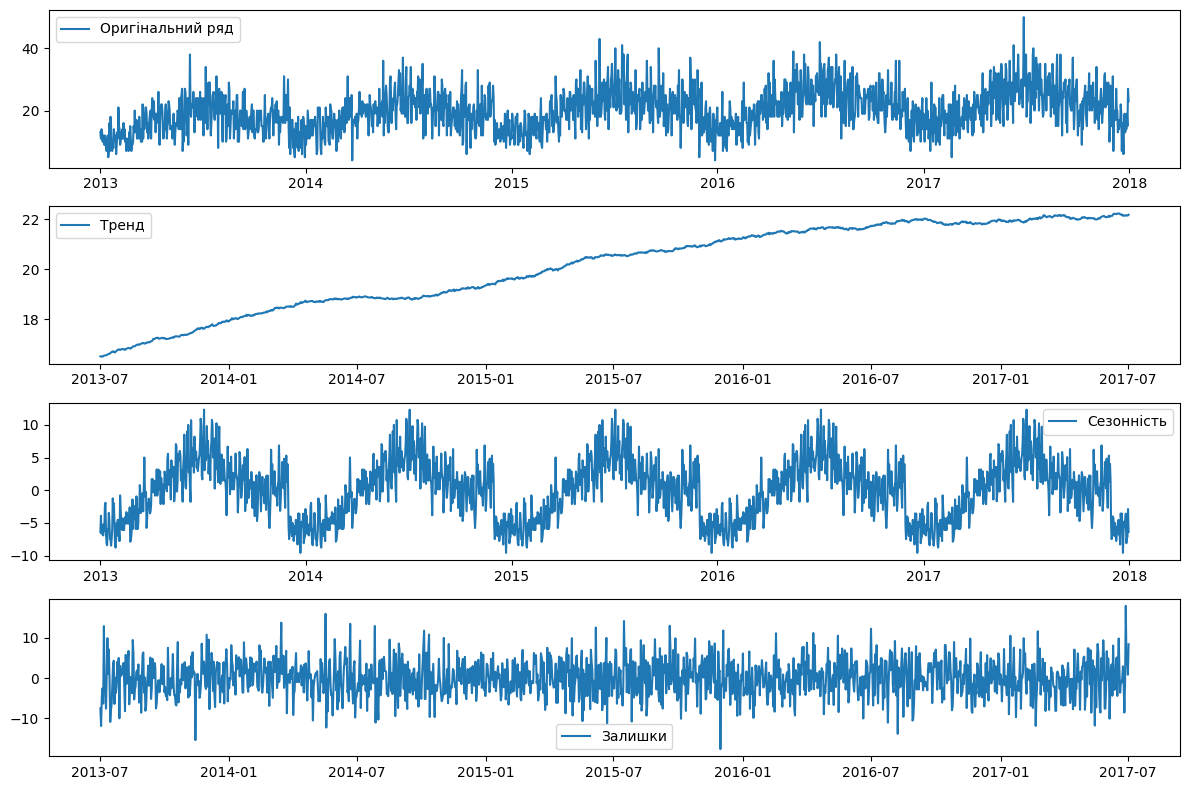

In [4]:
df_subset = df[(df["item"] == 1) & (df["store"] == 1)]
df_subset = df_subset.resample("D").sum()

decomposition = seasonal_decompose(df_subset["sales"], model="additive", period=365)

plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(df_subset["sales"], label="Оригінальний ряд")
plt.legend()

plt.subplot(412)
plt.plot(decomposition.trend, label="Тренд")
plt.legend()

plt.subplot(413)
plt.plot(decomposition.seasonal, label="Сезонність")
plt.legend()

plt.subplot(414)
plt.plot(decomposition.resid, label="Залишки")
plt.legend()

plt.tight_layout()
plt.show()


**Висновки**

Тренд. Показує стабільний і стійкий ріст.

Сезонність. Спостерігається чіткий річний цикл – кожного року є періоди підвищених та знижених продажів.

Залишки. Ніяких залежностей у залишках не видно.

4. Зі створеної підможени даних в попередньому пункті створіть обʼєкт класу `TimeSeries` в `darts` лише для колонки `sales`.

In [5]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.0/981.0 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.7 MB/s eta 0:00:00


In [6]:
from darts import TimeSeries

series = TimeSeries.from_dataframe(df_subset, value_cols="sales")

5. Використовуючи метод `series.split_before` розбийте дані на тренування і валідацію так, аби валідація починалась з `2017-10-01` включно.

  Візуалізуйте на одному графіку тренувальну і валідаційну частину як було показано в лекції.

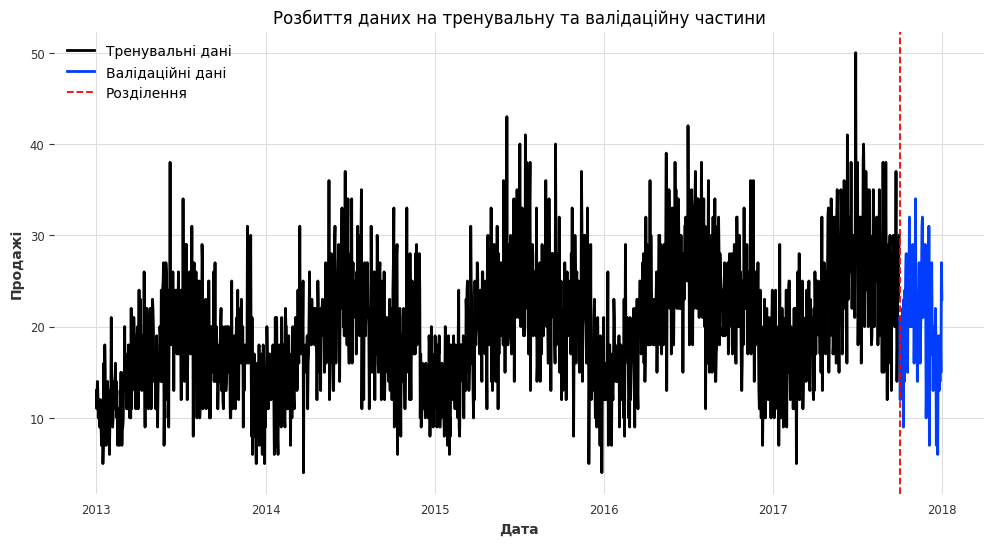

In [7]:
train, val = series.split_before(pd.Timestamp("2017-10-01"))

plt.figure(figsize=(12, 6))
train.plot(label="Тренувальні дані")
val.plot(label="Валідаційні дані")
plt.axvline(x=pd.Timestamp("2017-10-01"), color="red", linestyle="--", label="Розділення")
plt.legend()
plt.title("Розбиття даних на тренувальну та валідаційну частини")
plt.xlabel("Дата")
plt.ylabel("Продажі")
plt.show()

6. Побудуйте часткову автокореляційну фукнцію для цього нашого ряду в `series`. Напишіть висновки - які лаги є важливими для прогнозування?

<Figure size 1000x500 with 0 Axes>

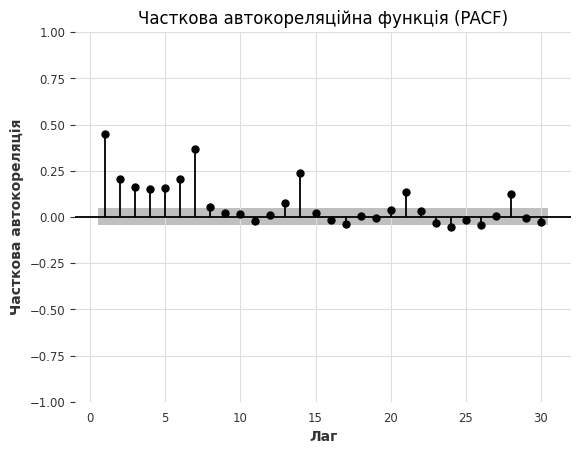

In [8]:
plt.figure(figsize=(10, 5))
plot_pacf(series.values(), lags=30, method="ywm", zero=False)
plt.title("Часткова автокореляційна функція (PACF)")
plt.xlabel("Лаг")
plt.ylabel("Часткова автокореляція")
plt.show()

**Висновки**

Значення у 1 лагу є великим. Це означає, що попередній продаж може слугувати для передбачення наступного.

Також, у графіку виділяється кожний сьомий лаг. Це може говорити про тижневу сезонність. Продажі у минулий понеділок можна використовувати для прогнозування у наступний понеділок. Продажі у минулий вівторок -- наступний вівторок тощо.



7. Виявіть сезональність тренувального ряду використовуючи фукнкцію `check_seasonality` з `darts`.

In [9]:
from darts.utils.statistics import check_seasonality

max_lag = len(train)

for m in [7, 14, 30, 100, 365]:
    if m <= max_lag:
        is_seasonal, period = check_seasonality(train, m=m, alpha=0.05, max_lag=max_lag)
        if is_seasonal:
            print(f"Виявлено сезонність з періодом {period} днів")


Виявлено сезонність з періодом 7 днів
Виявлено сезонність з періодом 14 днів


8. Побудуйте наївну модель NaiveSeasonal + NaieDrift для прогнозування даних. Кількість кроків для прогнозування визначіть зі свого аналізу в попередніх пунктах. Візуалізайте передбачення проти справжніх даних так, аби було видно якість передбачень. Зробіть висновок про модель. Вона точна?

  Якщо у вас є ідеї, як поліпшити якість передбачення саме наївними моделями - реалізуйте їх в цьому пункті :)

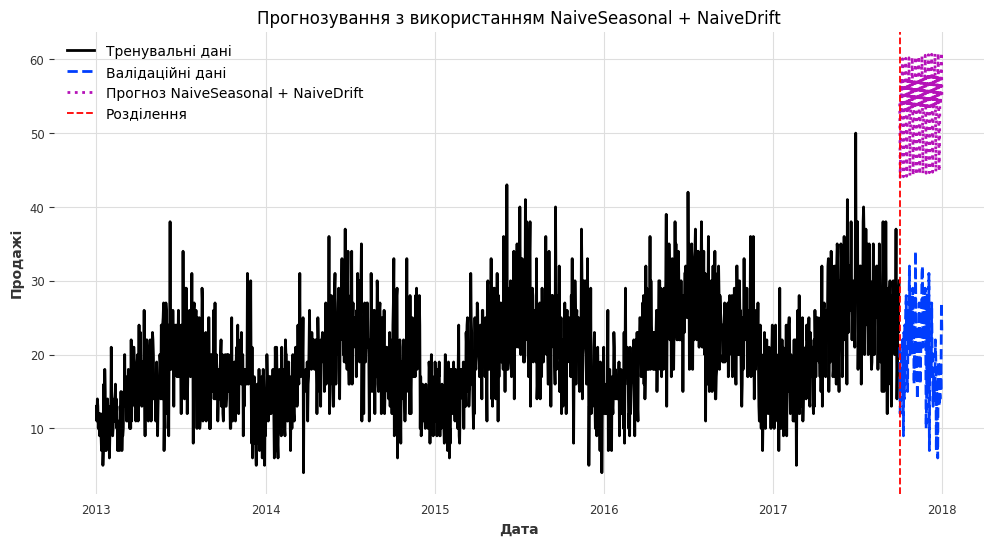

In [10]:
from darts.models import NaiveSeasonal, NaiveDrift

seasonal_period = 7
forecast_horizon = len(val)

seasonal_model = NaiveSeasonal(K=seasonal_period)
drift_model = NaiveDrift()

seasonal_model.fit(train)
drift_model.fit(train)

seasonal_forecast = seasonal_model.predict(forecast_horizon)
drift_forecast = drift_model.predict(forecast_horizon)

combined_forecast = seasonal_forecast + drift_forecast

plt.figure(figsize=(12, 6))
train.plot(label="Тренувальні дані")
val.plot(label="Валідаційні дані", linestyle="dashed")
combined_forecast.plot(label="Прогноз NaiveSeasonal + NaiveDrift", linestyle="dotted")
plt.axvline(x=pd.Timestamp("2017-10-01"), color="red", linestyle="--", label="Розділення")
plt.legend()
plt.title("Прогнозування з використанням NaiveSeasonal + NaiveDrift")
plt.xlabel("Дата")
plt.ylabel("Продажі")
plt.show()

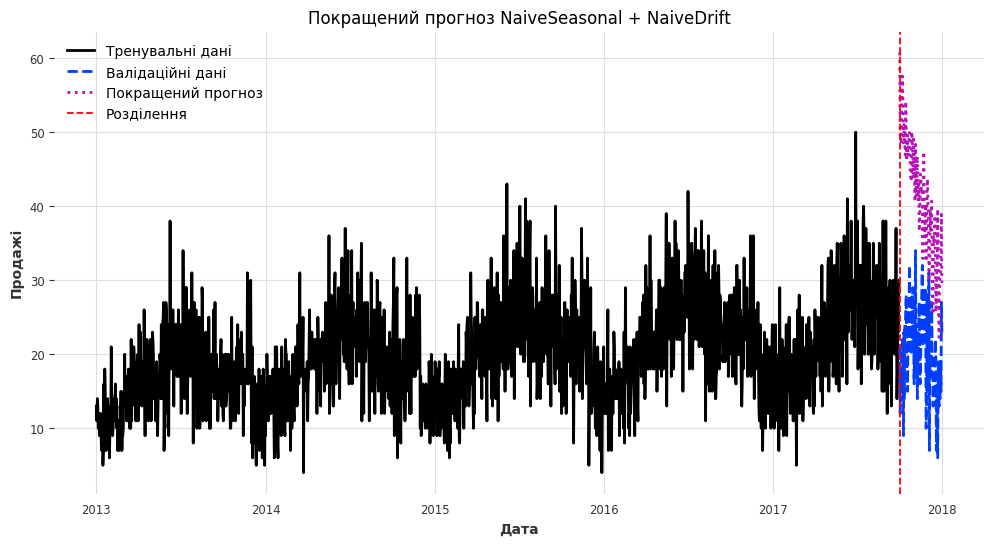

In [11]:
seasonal_period_1 = 7
seasonal_period_2 = 30

seasonal_model_1 = NaiveSeasonal(K=seasonal_period_1)
seasonal_model_2 = NaiveSeasonal(K=seasonal_period_2)
drift_model = NaiveDrift()

seasonal_model_1.fit(train)
seasonal_model_2.fit(train)
drift_model.fit(train[-30:])

seasonal_forecast_1 = seasonal_model_1.predict(forecast_horizon)
seasonal_forecast_2 = seasonal_model_2.predict(forecast_horizon)
drift_forecast = drift_model.predict(forecast_horizon)

improved_forecast = (seasonal_forecast_1 + seasonal_forecast_2) / 2 + drift_forecast

plt.figure(figsize=(12, 6))
train.plot(label="Тренувальні дані")
val.plot(label="Валідаційні дані", linestyle="dashed")
improved_forecast.plot(label="Покращений прогноз", linestyle="dotted")
plt.axvline(x=pd.Timestamp("2017-10-01"), color="red", linestyle="--", label="Розділення")
plt.legend()
plt.title("Покращений прогноз NaiveSeasonal + NaiveDrift")
plt.xlabel("Дата")
plt.ylabel("Продажі")
plt.show()

9. Обчисліть помилку прогнозу на валідації наївною моделлю з mape. Далі для всіх моделей необхідно обчислювати помилку прогнозу на валідації.

In [12]:
from darts.metrics import mape

error = mape(val, improved_forecast)

print(f"MAPE для покращеної наївної моделі: {error:.2f}%")

MAPE для покращеної наївної моделі: 122.62%


10. Натренуйте XBGModel з `darts` для передбачення наших даних. Можна додавати всі додаткові ознаки, які вважаєте за потрібне, наприклад, ознаки з дати. Зробіть висновок про якість моделі.

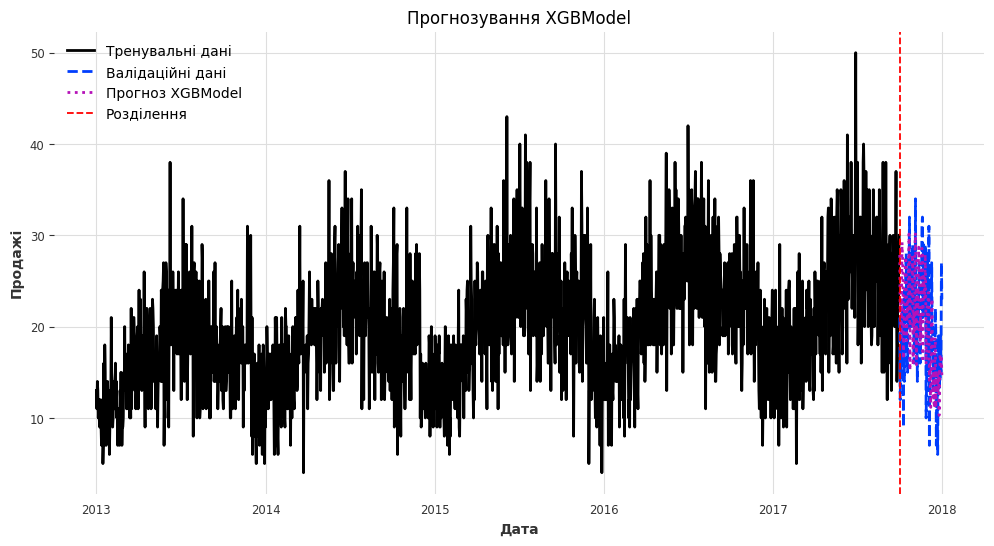

MAPE для XGBModel: 24.71%


In [13]:
from darts.models import XGBModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

scaler = Scaler()
train_scaled = scaler.fit_transform(train)

full_series = train.concatenate(val)

day_of_week = datetime_attribute_timeseries(full_series, attribute="dayofweek", one_hot=True)
month = datetime_attribute_timeseries(full_series, attribute="month", one_hot=True)
year = datetime_attribute_timeseries(full_series, attribute="year")

covariates = day_of_week.stack(month).stack(year)

xgb_model = XGBModel(lags=14, lags_past_covariates=[-30, -14, -7])

xgb_model.fit(train_scaled, past_covariates=covariates)

forecast_xgb = xgb_model.predict(len(val), past_covariates=covariates)

forecast_xgb = scaler.inverse_transform(forecast_xgb)

plt.figure(figsize=(12, 6))
train.plot(label="Тренувальні дані")
val.plot(label="Валідаційні дані", linestyle="dashed")
forecast_xgb.plot(label="Прогноз XGBModel", linestyle="dotted")
plt.axvline(x=pd.Timestamp("2017-10-01"), color="red", linestyle="--", label="Розділення")
plt.legend()
plt.title("Прогнозування XGBModel")
plt.xlabel("Дата")
plt.ylabel("Продажі")
plt.show()

error_xgb = mape(val, forecast_xgb)
print(f"MAPE для XGBModel: {error_xgb:.2f}%")


**Висновки**

Помилка вийшла 24%. Це багато, але набагато краще ніж у попередніх спробах.

Найприємніше у цій спробі -- модель змогла відобразити сезонність. Візуально це дуже видно. Наївна модель малювала наче навпаки.

11. Натренуйте модель ExponentialSmoothing та зробіть висновок про її якість.

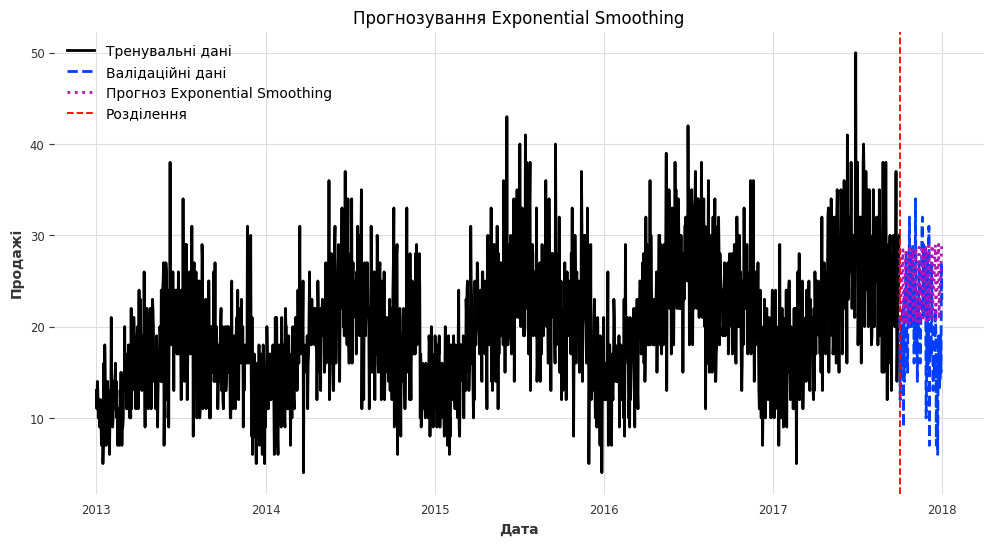

MAPE для Exponential Smoothing: 39.01%


In [14]:
from darts.models import ExponentialSmoothing

es_model = ExponentialSmoothing()
es_model.fit(train)

forecast_es = es_model.predict(len(val))

plt.figure(figsize=(12, 6))
train.plot(label="Тренувальні дані")
val.plot(label="Валідаційні дані", linestyle="dashed")
forecast_es.plot(label="Прогноз Exponential Smoothing", linestyle="dotted")
plt.axvline(x=pd.Timestamp("2017-10-01"), color="red", linestyle="--", label="Розділення")
plt.legend()
plt.title("Прогнозування Exponential Smoothing")
plt.xlabel("Дата")
plt.ylabel("Продажі")
plt.show()

error_es = mape(val, forecast_es)
print(f"MAPE для Exponential Smoothing: {error_es:.2f}%")


**Висновки**

Краще не стало. Кінець)

12. Натренуйте модель ARIMA, параметри оберіть самостійно.Зробіть висновок про її якість.

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


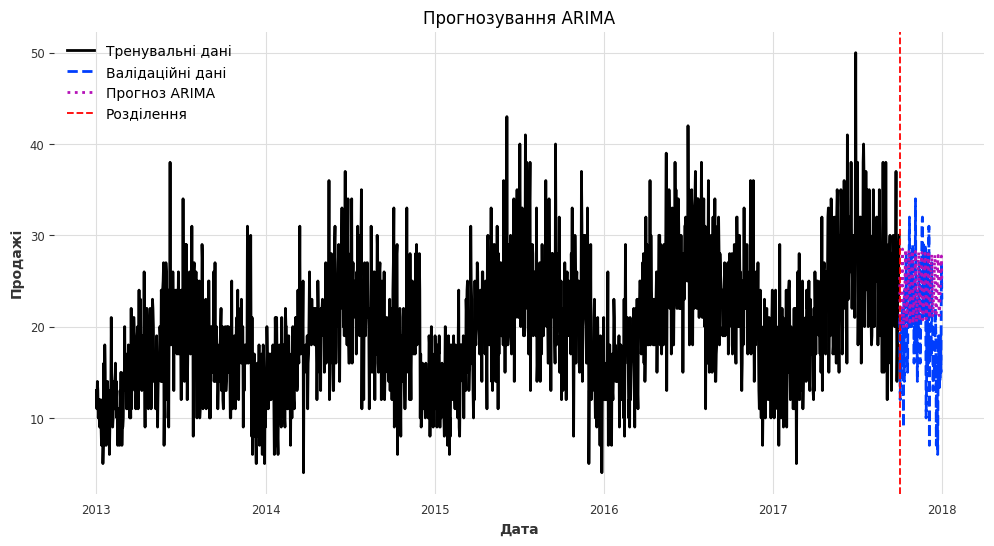

MAPE для ARIMA(7, 1, 7): 37.79%


In [15]:
from darts.models import ARIMA

p, d, q = 7, 1, 7

arima_model = ARIMA(p=p, d=d, q=q)
arima_model.fit(train)

forecast_arima = arima_model.predict(len(val))

plt.figure(figsize=(12, 6))
train.plot(label="Тренувальні дані")
val.plot(label="Валідаційні дані", linestyle="dashed")
forecast_arima.plot(label="Прогноз ARIMA", linestyle="dotted")
plt.axvline(x=pd.Timestamp("2017-10-01"), color="red", linestyle="--", label="Розділення")
plt.legend()
plt.title("Прогнозування ARIMA")
plt.xlabel("Дата")
plt.ylabel("Продажі")
plt.show()

error_arima = mape(val, forecast_arima)
print(f"MAPE для ARIMA({p}, {d}, {q}): {error_arima:.2f}%")


13. Знайдіть оптимальні параметри моделі ARIMA з допомогою AutoARIMA моделі. Виконайте пошук параметрів, виведіть, які паарметри виявились оптимальними і обчисліть якість моделі. Чи поліпшилась якість порівняно з попереднім експериментом?

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

AutoARIMA()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


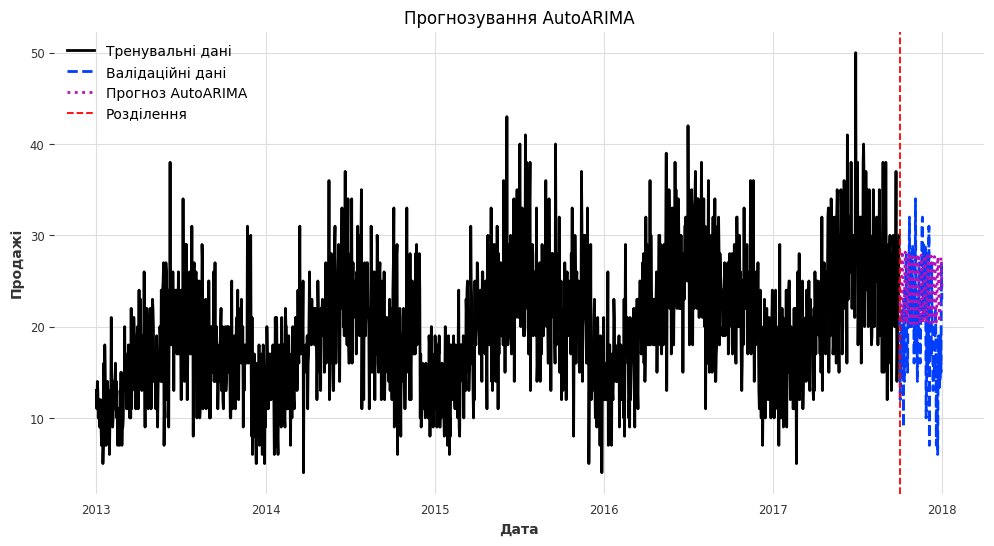

MAPE для AutoARIMA: 37.90%


In [19]:
from darts.models import AutoARIMA

auto_arima = AutoARIMA()
auto_arima.fit(train)

print(auto_arima.model)

forecast_auto_arima = auto_arima.predict(len(val))

plt.figure(figsize=(12, 6))
train.plot(label="Тренувальні дані")
val.plot(label="Валідаційні дані", linestyle="dashed")
forecast_auto_arima.plot(label="Прогноз AutoARIMA", linestyle="dotted")
plt.axvline(x=pd.Timestamp("2017-10-01"), color="red", linestyle="--", label="Розділення")
plt.legend()
plt.title("Прогнозування AutoARIMA")
plt.xlabel("Дата")
plt.ylabel("Продажі")
plt.show()

error_auto_arima = mape(val, forecast_auto_arima)
print(f"MAPE для AutoARIMA: {error_auto_arima:.2f}%")


**Висновки**

Все погано

14. Натренуйте модель Prophet та зробіть висновок про її якість.




INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzlztm5jz/a90el7zz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzlztm5jz/6qscwht1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47628', 'data', 'file=/tmp/tmpzlztm5jz/a90el7zz.json', 'init=/tmp/tmpzlztm5jz/6qscwht1.json', 'output', 'file=/tmp/tmpzlztm5jz/prophet_model8wgvjre3/prophet_model-20250312153734.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:37:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:37:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


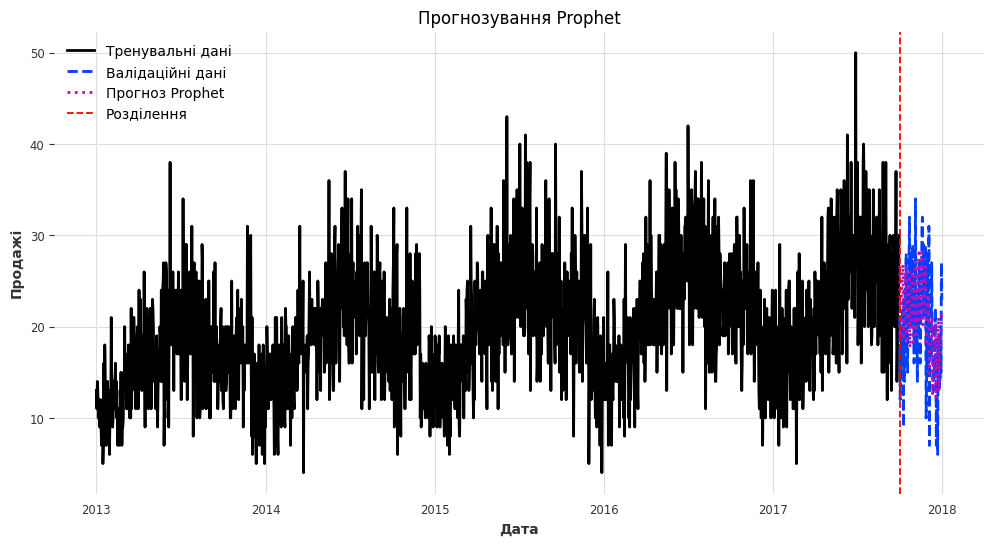

MAPE для Prophet: 23.80%


In [20]:
from darts.models import Prophet

prophet_model = Prophet()
prophet_model.fit(train)

forecast_prophet = prophet_model.predict(len(val))

plt.figure(figsize=(12, 6))
train.plot(label="Тренувальні дані")
val.plot(label="Валідаційні дані", linestyle="dashed")
forecast_prophet.plot(label="Прогноз Prophet", linestyle="dotted")
plt.axvline(x=pd.Timestamp("2017-10-01"), color="red", linestyle="--", label="Розділення")
plt.legend()
plt.title("Прогнозування Prophet")
plt.xlabel("Дата")
plt.ylabel("Продажі")
plt.show()

error_prophet = mape(val, forecast_prophet)
print(f"MAPE для Prophet: {error_prophet:.2f}%")


**Висновки**

Нарешті, хоч якийсь кращий результат.

15. Натренуйте модель `RNNModel` та зробіть висновок про її якість.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.8 K  | train
6 |

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:384: `ModelCheckpoint(monitor='val_loss')` could not find the monitored key in the returned metrics: ['train_loss', 'epoch', 'step']. HINT: Did you call `log('val_loss', value)` in the `LightningModule`?
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

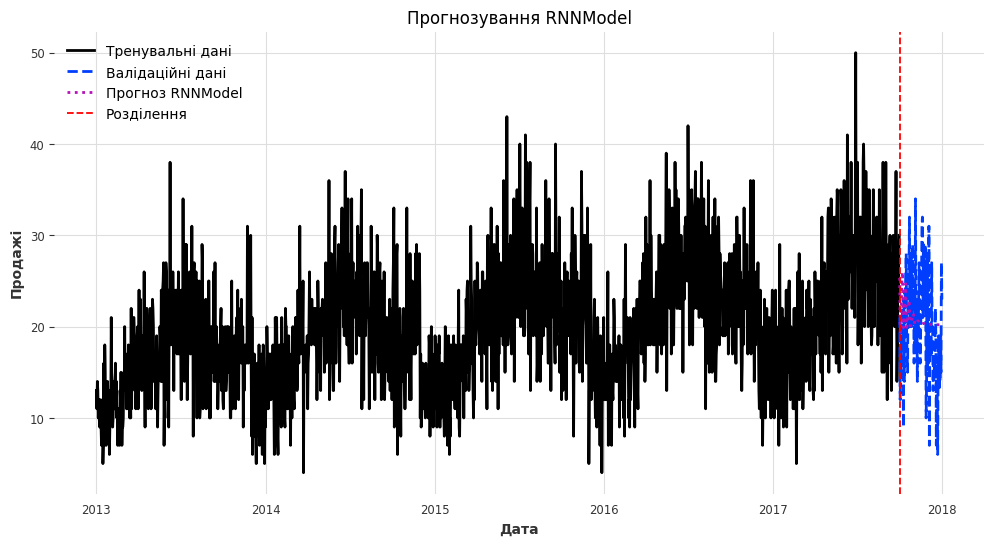

MAPE для RNNModel: 28.76%


In [23]:
from darts.models import RNNModel

rnn_model = RNNModel(
    model="LSTM",
    input_chunk_length=14,  # Використовуємо 14 попередніх днів
    output_chunk_length=7,  # Прогнозуємо на 7 днів вперед
    n_epochs=100,  # Кількість епох
    random_state=42,
    dropout=0.2,  # Додаємо Dropout для регуляризації
    batch_size=16,
    optimizer_kwargs={"lr": 1e-3},  # Налаштування оптимізатора
    model_name="rnn_model",
    save_checkpoints=True
)

# Навчання моделі
rnn_model.fit(train, verbose=True)

# Прогнозування
forecast_rnn = rnn_model.predict(len(val))

# Візуалізація прогнозу
plt.figure(figsize=(12, 6))
train.plot(label="Тренувальні дані")
val.plot(label="Валідаційні дані", linestyle="dashed")
forecast_rnn.plot(label="Прогноз RNNModel", linestyle="dotted")
plt.axvline(x=pd.Timestamp("2017-10-01"), color="red", linestyle="--", label="Розділення")
plt.legend()
plt.title("Прогнозування RNNModel")
plt.xlabel("Дата")
plt.ylabel("Продажі")
plt.show()

# Обчислення MAPE
error_rnn = mape(val, forecast_rnn)
print(f"MAPE для RNNModel: {error_rnn:.2f}%")


16. Виконайте бектест для тої моделі, яка виявилась найкращою у вашому дослідженні на періоді 1 рік з передбаченнями на 1 місяць щоразу. Візуалізуйте як поводилась модель протягом бектесту, яка була точність?

historical forecasts:   0%|          | 0/12 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzlztm5jz/78l9ujjl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzlztm5jz/tg19l2b7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24756', 'data', 'file=/tmp/tmpzlztm5jz/78l9ujjl.json', 'init=/tmp/tmpzlztm5jz/tg19l2b7.json', 'output', 'file=/tmp/tmpzlztm5jz/prophet_model8v6bfszh/prophet_model-20250312161607.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:16:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:16:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
historical forecasts:   8%|▊         | 1/12 [00:00<00:07,  1.52it/s]INFO:prophet:D

Середній MAPE для Prophet на бек-тесті: 10.06%


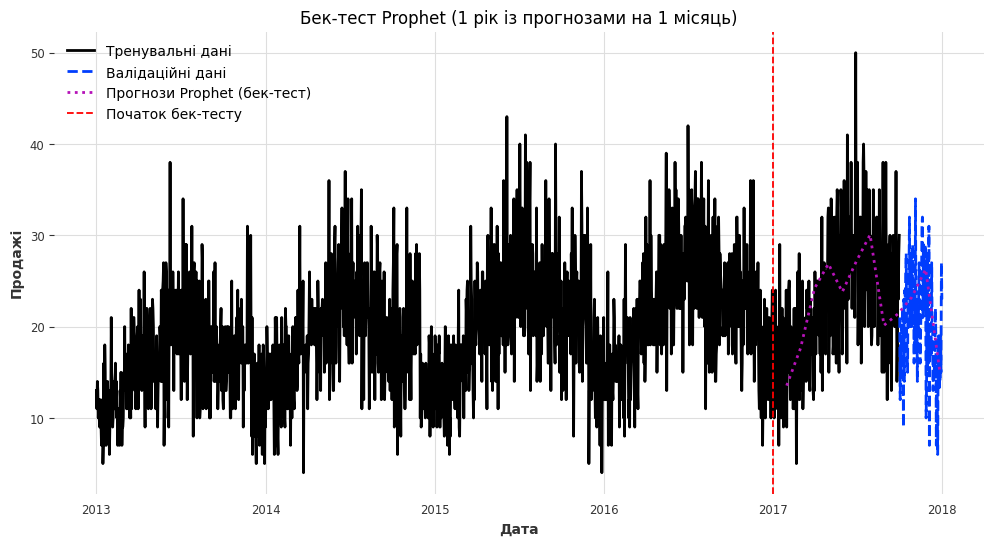

In [24]:
backtest_results = prophet_model.historical_forecasts(
    series=train.concatenate(val),
    start=pd.Timestamp("2017-01-01"),
    forecast_horizon=30,
    stride=30,
    retrain=True,
    verbose=True
)

error_backtest = mape(val, backtest_results)
print(f"Середній MAPE для Prophet на бек-тесті: {error_backtest:.2f}%")

plt.figure(figsize=(12, 6))
train.plot(label="Тренувальні дані")
val.plot(label="Валідаційні дані", linestyle="dashed")
backtest_results.plot(label="Прогнози Prophet (бек-тест)", linestyle="dotted")
plt.axvline(x=pd.Timestamp("2017-01-01"), color="red", linestyle="--", label="Початок бек-тесту")
plt.legend()
plt.title("Бек-тест Prophet (1 рік із прогнозами на 1 місяць)")
plt.xlabel("Дата")
plt.ylabel("Продажі")
plt.show()

**Висновки**



17. На цьому етапі ви зрозуміли, як моделювати продажі одного айтему з 1 магазину. Як би ви підійшли до задачі прогнозування продажів в наступному місяці для кожного з 50 айтемів в кожному з 10 магазинів? Опишіть загальний підхід
- яку модель ви б використали
- скільки моделей ви б тренували
- обгрунтуйте свій вибір.

Оскільки ми хочемо прогнозувати продажі 50 товарів у 10 магазинах (тобто виходить 500 унікальних часових рядів), можна спробувати враховувати індивідуальні особливості кожного ряду та спільні закономірності між магазинами та товарами.

Звісно, мені найбільше сподобався результат моделі Prophet, тому хотілось би котапи в цю сторону.

Можна було б натренувати 500 Prophet моделей. А можливо і спробувати всі моделі з цього уроку. Може у випадку роботи з кожним із 500 рядів якийсь інший підхід спрацює краще.